In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
from IPython.display import display
from scipy.interpolate import interp1d
import seaborn as sns
import tensorflow as tf
import scipy

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
from pathlib import Path
data_dir = Path("../data/ts_data/")

data = {}
for csv_file in data_dir.glob("*.csv"):
        
    this_csv = pd.read_csv(csv_file, delimiter=",")
    
    this_csv['DATE_TIME'] = pd.to_datetime(this_csv['TIME'],unit='s').dt.tz_localize("UTC")
    this_csv = this_csv.set_index('DATE_TIME', drop=False).sort_index()
    
    data[csv_file.stem] = this_csv.sort_values("TIME")

In [6]:
from pathlib import Path
data_dir = Path("/home/di40438/bachelorarbeit/data/")

data = {}
for csv_file in data_dir.glob("*.csv"):
    if csv_file.stem in ["schmelzen", "FormateCC4"]:continue
        
    this_csv = pd.read_csv(csv_file, delimiter=";")
    
    this_csv['DATE_TIME'] = pd.to_datetime(this_csv['TIME'],unit='s').dt.tz_localize("UTC")
    this_csv = this_csv.set_index('DATE_TIME', drop=False).sort_index()
    
    data[csv_file.stem] = this_csv.sort_values("TIME")
    #display( data[csv_file.stem].tail())
    
data['TundishTemperaturInC'] = data['TundishTemperaturInC'][(data['TundishTemperaturInC']['TundishTemperaturInC'] < 1600) & (data['TundishTemperaturInC']['TundishTemperaturInC'] > 1400)]  
    

### Import df_schmelzen

In [8]:
df_schmelzen = pd.read_pickle("/home/di40438/bachelorarbeit/data/df_schmelzen.pkl")
# df_schmelzen = df_schmelzen.sort_values('GiessBeginnSchmelze')
# df_schmelzen = df_schmelzen.fillna(0)

## Combine df_schmelzen and length_seq_str_2  with 90min added to 'GiessEnde'

In [9]:
merged = []

for _, row in data['Str2GiessLaengeSequenzInM'].iterrows():
    schmelze = df_schmelzen[(df_schmelzen["GiessBeginn_DateTime"] < row["DATE_TIME"]) & (df_schmelzen["Ende_DateTime"] >= row["DATE_TIME"])]
    if len(schmelze) != 1:
        continue
    merged.append(pd.concat([row.to_frame().transpose().reset_index(drop=True), schmelze.reset_index(drop=True)], axis=1))

df_str2_extended = pd.concat(merged)
df_str2_extended = df_str2_extended.reset_index(drop=True)

## Combine df_schmelzen and length_seq_str_2

In [11]:
merged = []

for _, row in data['Str2GiessLaengeSequenzInM'].iterrows():
    schmelze = df_schmelzen[(df_schmelzen["GiessBeginn_DateTime"] < row["DATE_TIME"]) & (df_schmelzen["GiessEnde_DateTime"] >= row["DATE_TIME"])]
    if len(schmelze) != 1:
        continue
    merged.append(pd.concat([row.to_frame().transpose().reset_index(drop=True), schmelze.reset_index(drop=True)], axis=1))

df_merged_str2 = pd.concat(merged)
df_merged_str2 = df_merged_str2.reset_index(drop=True)

## Combine df_schmelzen and length_seq_str_2 nothing added to 'GiessEnde'

In [13]:
merged = []

for _, row in data['Str2GiessLaengeSchmelzeInM'].iterrows():
    schmelze = df_schmelzen[(df_schmelzen["GiessBeginn_DateTime"] < row["DATE_TIME"]) & (df_schmelzen["GiessEnde_DateTime"] >= row["DATE_TIME"])]
    if len(schmelze) != 1:
        continue
    merged.append(pd.concat([row.to_frame().transpose().reset_index(drop=True), schmelze.reset_index(drop=True)], axis=1))

df_str2_schmelzen = pd.concat(merged)
df_str2_schmelzen = df_str2_schmelzen.reset_index(drop=True)

## Create interpolated Data

In [15]:
rng = pd.date_range(start='2019-05-15 11:31:00+00:00', end='2019-08-30 23:59:00+00:00', freq='30s')
df_times = pd.DataFrame({'DateTime': rng})
df_times['ts'] = df_times.DateTime.values.astype(np.int64) // 10**9    #np arry by values, then 10**9 for ns

In [16]:
df_sch_str2 = data['Str2GiessLaengeSchmelzeInM'].copy()
time = df_sch_str2['TIME'].to_numpy() 
length = df_sch_str2['Str2GiessLaengeSchmelzeInM'].to_numpy()

from scipy.interpolate import interp1d
interp_s = interp1d(time, length, kind='linear')

new_time = df_times['ts'].to_numpy()

inter_array = interp_s(new_time)

schmelze_str2_inter = pd.DataFrame({'DATE_TIME':new_time , 'Str2GiessLaengeSchmelzeInM': inter_array, 'TIME': new_time})
schmelze_str2_inter['DATE_TIME'] = pd.to_datetime(schmelze_str2_inter['DATE_TIME'],unit='s').dt.tz_localize("UTC")
schmelze_str2_inter.head()

,DATE_TIME,Str2GiessLaengeSchmelzeInM,TIME
0,2019-05-15 11:31:00+00:00,0.35,1557919860
1,2019-05-15 11:31:30+00:00,0.35,1557919890
2,2019-05-15 11:32:00+00:00,0.35,1557919920
3,2019-05-15 11:32:30+00:00,0.35,1557919950
4,2019-05-15 11:33:00+00:00,0.35,1557919980


### Interpolated Sequence data

In [17]:
df_seq_str2 = data['Str2GiessLaengeSequenzInM'].copy()

time = df_seq_str2['TIME'].to_numpy() 
length = df_seq_str2['Str2GiessLaengeSequenzInM'].to_numpy()

from scipy.interpolate import interp1d
interp_s = interp1d(time, length, kind='linear')

new_time = df_times['ts'].to_numpy()

inter_array = interp_s(new_time)

str2_inter = pd.DataFrame({'DATE_TIME':new_time , 'Str2GiessLaengeSequenzInM': inter_array, 'TIME': new_time})
str2_inter['DATE_TIME'] = pd.to_datetime(str2_inter['DATE_TIME'],unit='s').dt.tz_localize("UTC")
str2_inter.head()

,DATE_TIME,Str2GiessLaengeSequenzInM,TIME
0,2019-05-15 11:31:00+00:00,0.35,1557919860
1,2019-05-15 11:31:30+00:00,0.35,1557919890
2,2019-05-15 11:32:00+00:00,0.35,1557919920
3,2019-05-15 11:32:30+00:00,0.35,1557919950
4,2019-05-15 11:33:00+00:00,0.35,1557919980


## Combine df_schmelzen and str2_inter with 90min added to 'GiessEnde'

In [20]:
merged = []

for _, row in str2_inter.iterrows():
    schmelze = df_schmelzen[(df_schmelzen["GiessBeginn_DateTime"] < row["DATE_TIME"]) & (df_schmelzen["Ende_DateTime"] >= row["DATE_TIME"])]
    if len(schmelze) != 1:
        continue
    merged.append(pd.concat([row.to_frame().transpose().reset_index(drop=True), schmelze.reset_index(drop=True)], axis=1))

str2_inter_extended = pd.concat(merged)
str2_inter_extended = str2_inter_extended.reset_index(drop=True)

## Combine df_schmelzen and str2_inter (nothing added)

In [24]:
merged = []

for _, row in str2_inter.iterrows():
    schmelze = df_schmelzen[(df_schmelzen["GiessBeginn_DateTime"] < row["DATE_TIME"]) & (df_schmelzen["GiessEnde_DateTime"] >= row["DATE_TIME"])]
    if len(schmelze) != 1:
        continue
    merged.append(pd.concat([row.to_frame().transpose().reset_index(drop=True), schmelze.reset_index(drop=True)], axis=1))

df_str2_inter = pd.concat(merged)
df_str2_inter = df_str2_inter.reset_index(drop=True)

## Combine df_schmelzen and schmelze_str2_inter (nothing added)

In [27]:
merged = []

for _, row in schmelze_str2_inter.iterrows():
    schmelze = df_schmelzen[(df_schmelzen["GiessBeginn_DateTime"] < row["DATE_TIME"]) & (df_schmelzen["GiessEnde_DateTime"] >= row["DATE_TIME"])]
    if len(schmelze) != 1:
        continue
    merged.append(pd.concat([row.to_frame().transpose().reset_index(drop=True), schmelze.reset_index(drop=True)], axis=1))

df_str2_schmelzen = pd.concat(merged)
df_str2_schmelzen = df_str2_schmelzen.reset_index(drop=True)

### Outliar detection: Get Outliars with Schmelzen data

In [16]:
str2_schmelzen_grouped = str2_schmelzen.groupby(str2_schmelzen['ChargenNr'])
df_schmelzen_max = str2_schmelzen_grouped['Str2GiessLaengeSchmelzeInM'].max().to_frame()
df_schmelzen_max = df_schmelzen_max.rename(columns={'Str2GiessLaengeSchmelzeInM': 'Str2GiessLaengeSchmelzeInM_max'})
df_schmelzen_max = df_schmelzen_max.reset_index(drop=False)

In [17]:
df_schmelzen_max.min()

ChargenNr                         471719.000000
Str2GiessLaengeSchmelzeInM_max         5.833705
dtype: float64

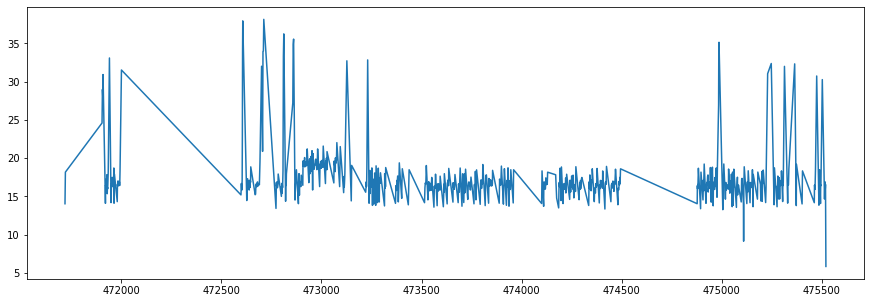

In [18]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,1,1)
ax1.plot('ChargenNr', 'Str2GiessLaengeSchmelzeInM_max', data = df_schmelzen_max)

In [19]:
schmelzen_drop = df_schmelzen_max[df_schmelzen_max['Str2GiessLaengeSchmelzeInM_max']<8]
schmelzen_drop = schmelzen_drop['ChargenNr'].to_numpy()
schmelzen_drop

array([475520])

### Look at min charge

In [21]:
str2_schmelzen_grouped = str2_schmelzen.groupby(str2_schmelzen['ChargenNr'])
df_schmelzen_min = str2_schmelzen_grouped['Str2GiessLaengeSchmelzeInM'].min().to_frame()
df_schmelzen_min = df_schmelzen_min.rename(columns={'Str2GiessLaengeSchmelzeInM': 'Str2GiessLaengeSchmelzeInM_min'})
df_schmelzen_min = df_schmelzen_min.reset_index(drop=False)

In [22]:
df_schmelzen_min.max()

ChargenNr                         475520.000000
Str2GiessLaengeSchmelzeInM_min         9.193015
dtype: float64

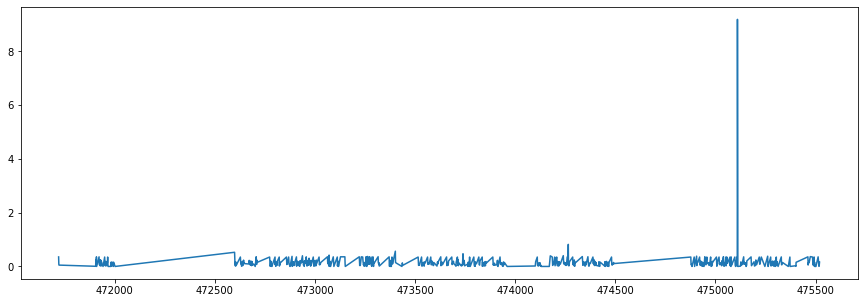

In [23]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,1,1)
ax1.plot('ChargenNr', 'Str2GiessLaengeSchmelzeInM_min', data = df_schmelzen_min)

In [24]:
s = df_schmelzen_min[df_schmelzen_min['Str2GiessLaengeSchmelzeInM_min']>2]
s = s['ChargenNr'].to_numpy()
schmelzen_drop = np.append(schmelzen_drop,s)


### identify the sequences of schmelzen_drop

In [26]:
schmelzen = pd.read_pickle("/home/di40438/bachelorarbeit/data/df_schmelzen.pkl")

schmelzen = schmelzen.set_index('ChargenNr',drop=True)

seq_drop = schmelzen.loc[schmelzen_drop]

seq_drop = seq_drop['ChargenNrErsteSchmInSeq']
seq_drop = seq_drop.drop_duplicates(keep='first')
seq_drop = seq_drop.reset_index(drop=True)

In [27]:
seq_drop

0    475513
1    475108
Name: ChargenNrErsteSchmInSeq, dtype: int64

## Drop Schmelzen - create df_strang_2

In [44]:
df_interv.head()

,DATE_TIME,Str2GiessLaengeSequenzInM,TIME,ChargenNr,ChargenNrErsteSchmInSeq,GiessBeginnSchmelze,GiessBeginn_DateTime,GiessEndeSchmelze,GiessEnde_DateTime,EndeSchmelze,Ende_DateTime,NrSchmelzeInSequenz,LiquidusTempInC,SolidusTempInC,UeberhitzungMittelInK,ZielTempTreiberInC,Str1SollGiessGeschwInMproMin,Str2SollGiessGeschwInMproMin,Str1Format,Str2Format,C-Aequiv01,C-Aequiv02,C-AequivP
0,2019-05-15 11:39:30+00:00,0.354328,1557920370,471719,471719,1.557920e+09,2019-05-15 11:39:23.490000010+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1,1517.8,1470.357,53.2,720,0.315,0.315,2235,2235,0.31285,0.32335,0.131067
1,2019-05-15 11:40:00+00:00,0.373475,1557920400,471719,471719,1.557920e+09,2019-05-15 11:39:23.490000010+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1,1517.8,1470.357,53.2,720,0.315,0.315,2235,2235,0.31285,0.32335,0.131067
2,2019-05-15 11:40:30+00:00,0.413803,1557920430,471719,471719,1.557920e+09,2019-05-15 11:39:23.490000010+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1,1517.8,1470.357,53.2,720,0.315,0.315,2235,2235,0.31285,0.32335,0.131067
3,2019-05-15 11:41:00+00:00,0.465738,1557920460,471719,471719,1.557920e+09,2019-05-15 11:39:23.490000010+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1,1517.8,1470.357,53.2,720,0.315,0.315,2235,2235,0.31285,0.32335,0.131067
4,2019-05-15 11:41:30+00:00,0.535082,1557920490,471719,471719,1.557920e+09,2019-05-15 11:39:23.490000010+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1,1517.8,1470.357,53.2,720,0.315,0.315,2235,2235,0.31285,0.32335,0.131067


In [46]:
df_interv = df_interv.set_index(df_interv['ChargenNrErsteSchmInSeq'],drop=True)
df_interv = df_interv.drop(seq_drop, axis=0)
df_interv = df_interv.reset_index(drop=True)

## Create df_chargen_nr

### calculate min and max for each charge

In [49]:
df_interv_grouped = df_interv.groupby(df_interv['ChargenNr'])

df_interv_grouped_max = df_interv_grouped['Str2GiessLaengeSequenzInM'].max().to_frame()
df_interv_grouped_min = df_interv_grouped['Str2GiessLaengeSequenzInM'].min().to_frame()

df_interv_grouped_max = df_interv_grouped_max.rename(columns={'Str2GiessLaengeSequenzInM': 'Str2GiessLaengeSequenzInM_max'})

df_interv_grouped_min = df_interv_grouped_min.rename(columns={'Str2GiessLaengeSequenzInM': 'Str2GiessLaengeSequenzInM_min'})

chargen_nr = pd.merge(df_interv_grouped_min,df_interv_grouped_max,on=['ChargenNr'],
                                            how='outer')

chargen_nr = chargen_nr.reset_index(drop=False)

In [50]:
chargen_nr.head()

,ChargenNr,Str2GiessLaengeSequenzInM_min,Str2GiessLaengeSequenzInM_max
0,471719,0.354328,14.029082
1,471720,14.186951,30.760393
2,471721,30.918246,83.334000
3,471904,0.394230,24.833213
4,471905,25.083050,52.340639


#### set min = 0:

In [53]:
def set_value_to_zero (row):
    if row['Str2GiessLaengeSequenzInM_min'] < 1:
        row['Str2GiessLaengeSequenzInM_min'] = 0
    return row


In [54]:
chargen_zero = chargen_nr.apply(set_value_to_zero, axis=1)

In [55]:
chargen_zero.head()

,ChargenNr,Str2GiessLaengeSequenzInM_min,Str2GiessLaengeSequenzInM_max
0,471719.0,0.000000,14.029082
1,471720.0,14.186951,30.760393
2,471721.0,30.918246,83.334000
3,471904.0,0.000000,24.833213
4,471905.0,25.083050,52.340639


### Merge df_schmelzen and chargen_zero to get seq_id

In [57]:
df_chargen = pd.merge(chargen_zero,df_schmelzen[['ChargenNr','ChargenNrErsteSchmInSeq']],on=['ChargenNr'],
                                            how='inner')
df_chargen = pd.merge(df_chargen,df_schmelzen[['ChargenNr','GiessBeginn_DateTime']],on=['ChargenNr'],
                                            how='inner')  #to sort the values, sometimes the chargen_nr is not ascending order

df_chargen =df_chargen.set_index('GiessBeginn_DateTime', drop=False).sort_index()

df_chargen = df_chargen.reset_index(drop=True)
df_chargen = df_chargen.drop('GiessBeginn_DateTime', axis=1)

In [58]:
df_chargen.head()

,ChargenNr,Str2GiessLaengeSequenzInM_min,Str2GiessLaengeSequenzInM_max,ChargenNrErsteSchmInSeq
0,471719.0,0.000000,14.029082,471719
1,471720.0,14.186951,30.760393,471719
2,471721.0,30.918246,83.334000,471719
3,471904.0,0.000000,24.833213,471904
4,471905.0,25.083050,52.340639,471904


### chargen_old

In [59]:
df_chargen_old = df_chargen.copy()

#### set 'Str2GiessLaengeSequenzInM_min' of i equal to 'Str2GiessLaengeSequenzInM_max' of i-1

In [61]:
df_chargen['Str2GiessLaengeSequenzInM_max_prev'] = df_chargen['Str2GiessLaengeSequenzInM_max'].shift(1)
df_chargen['ChargenNrErsteSchmInSeq_prev'] = df_chargen['ChargenNrErsteSchmInSeq'].shift(1)

def set_min (row):
    if row['ChargenNrErsteSchmInSeq_prev'] == row['ChargenNrErsteSchmInSeq']:
        row['Str2GiessLaengeSequenzInM_min'] = row['Str2GiessLaengeSequenzInM_max_prev']
    return row

df_chargen_nr = df_chargen.apply(set_min, axis=1)
df_chargen_nr = df_chargen_nr.drop(['Str2GiessLaengeSequenzInM_max_prev','ChargenNrErsteSchmInSeq_prev' ], axis=1)

In [64]:
df_chargen_nr.head()

,ChargenNr,Str2GiessLaengeSequenzInM_min,Str2GiessLaengeSequenzInM_max,ChargenNrErsteSchmInSeq
0,471719.0,0.000000,14.029082,471719.0
1,471720.0,14.029082,30.760393,471719.0
2,471721.0,30.760393,83.334000,471719.0
3,471904.0,0.000000,24.833213,471904.0
4,471905.0,24.833213,52.340639,471904.0


## Remove time dependence by assigning the specific cooling zone in which each section is 

In [9]:
def get_charNr(time, seq_nr):
    try:
        return df_schmelzen.loc[(((df_schmelzen['GiessBeginnSchmelze'] <= time) & (df_schmelzen['EndeSchmelze'] >= time)) & (df_schmelzen['ChargenNrErsteSchmInSeq'] == seq_nr)), ['ChargenNr']].to_numpy()[0][0]
    except IndexError: #wenn die Zeitpunkte genau mit den Grenzen der Gießzeitpunkte übereinstimmen kommt es zum IndexError
        return df_schmelzen.loc[(((df_schmelzen['GiessBeginnSchmelze'] <= np.round(time.item(),-1)) & (df_schmelzen['EndeSchmelze'] >=  (np.round(time.item(),-1))-1)) & (df_schmelzen['ChargenNrErsteSchmInSeq'] == seq_nr)), ['ChargenNr']].to_numpy()[0][0]

def get_charNr(time, seq_nr):
    for i in range(10):
        try:
            if i == 0:
                return df_schmelzen.loc[(((df_schmelzen['GiessBeginnSchmelze'] <= time) & (df_schmelzen['EndeSchmelze'] >= time)) & (df_schmelzen['ChargenNrErsteSchmInSeq'] == seq_nr)), ['ChargenNr']].to_numpy()[0][0]
            return df_schmelzen.loc[(((df_schmelzen['GiessBeginnSchmelze'] <= np.round(time.item(),-1)) & (df_schmelzen['EndeSchmelze'] >=  (np.round(time.item(),-1))-i)) & (df_schmelzen['ChargenNrErsteSchmInSeq'] == seq_nr)), ['ChargenNr']].to_numpy()[0][0]
        except IndexError:
            print("Didn't work")
            continue
    raise ValueError("Didn't find it even after 10 tries")

def charNr(row):
    time =row['z1_begin_time']
    row['ChargenNr'] = get_charNr(time, row['SequenzNr'])
    return row    

df_chargen_nr = pd.read_pickle("/home/di40438/bachelorarbeit/data/chargen_nr_str2.pkl")

# Zonen Start und Ende
zonen = {'z1':[0.62,2.17],'z2a':[2.17,3.52],'z2b':[3.52,5.44],'z3a':[5.44,7.18],'z3b':[7.18,9.1],'z4':[9.1,11.02],'z5':[11.02,14.42],'zpy':[15.42,15.42]}

schmelzen_drop = [475520, 475110]

# seq_max = pd.read_pickle("/home/di40438/bachelorarbeit/data/merged_2_all.pkl") #'sequenz_laenge' nur bis zum Giessende 

seq_drop = pd.read_pickle("/home/di40438/bachelorarbeit/data/seq_drop_str_2.pkl")

seq_max = pd.read_pickle("/home/di40438/bachelorarbeit/data/df_str2_inter.pkl") #'sequenz_laenge' nur bis zum Giessende 

seq_max = seq_max.set_index(seq_max['ChargenNr'],drop=True)

seq_max = seq_max.drop(schmelzen_drop, axis=0)  #drop the chargen from the outliar detection (sequences were already dropped)

seq_max = seq_max.reset_index(drop=True)

str2_seq = pd.read_pickle("/home/di40438/bachelorarbeit/data/df_strang_2.pkl") #sequenz_laenge auch noch später als Giessende

sequence_nr = pd.read_pickle("/home/di40438/bachelorarbeit/data/df_strang_2.pkl")
sequence_nr = sequence_nr['ChargenNrErsteSchmInSeq']
sequence_nr = sequence_nr.drop_duplicates(keep='first')
sequence_nr = sequence_nr.reset_index(drop=True)

In [21]:
str2_data = {}
for sequence in tqdm(sequence_nr):
    seq_max_length = seq_max[seq_max['ChargenNrErsteSchmInSeq']==sequence]
    seq_max_length = seq_max_length.reset_index(drop=True)

    seq = str2_seq[str2_seq['ChargenNrErsteSchmInSeq']==sequence]
    seq = seq.reset_index(drop=True)

    gil = seq['Str2GiessLaengeSequenzInM']  # Länge der Strecke, die das Förderband zurückgelegt hat
    max_gil = np.max(gil)   # maximale Länge der Strecke, die das Förderband zurückgelegt hat
    max_meter = np.max(seq_max_length['Str2GiessLaengeSequenzInM']) # tatsächliche maximale Länge der Schmelze 

    arr = np.arange(0, max_gil, 0.01)
    df_length = pd.DataFrame({'length': arr})

    time = seq['TIME'].to_numpy() 
    length = seq['Str2GiessLaengeSequenzInM'].to_numpy()

    from scipy.interpolate import interp1d
    interp = interp1d(length, time, kind='linear')
    
    gilz = []
    cnt  = 0
    section_length = 0.33        #Länge der Abschnitte in Meter
    for section in range(int(np.max((max_meter+section_length)/section_length))):    #für jeden Meter der Sequenz (der ite Meter)
        gilz.append({})
        for z in zonen:        #jede Zone --> Verfolgen jedes Meters durch jede Zone
            mnt = 0
            mxt = 0

            mnt = interp(zonen[z][0]+(section*section_length))
            mxt = interp(zonen[z][1]+((section+1)*section_length))
            dt  = mxt-mnt

            gilz[-1][z] = [mnt,mxt,dt]

    seq_df = pd.DataFrame()
    for section in range(len(gilz)):
        z_df = pd.DataFrame()
        for z in zonen:
            section_z_df = pd.DataFrame(gilz[section][z], index=[z+'_begin_time',z+'_end_time',z+'_delta_time']).transpose()
            z_df = pd.concat([z_df, section_z_df], axis=1)

        seq_df = pd.concat([seq_df,z_df], axis=0)

        seq_df['SequenzNr'] = seq['ChargenNrErsteSchmInSeq']
        seq_df = seq_df.apply(charNr, axis=1)
        seq_df = seq_df.reindex(sorted(seq_df.columns), axis=1)
        seq_df = seq_df.reset_index(drop=True)

        str2_data[sequence] = seq_df.copy()

  2%|▏         | 2/116 [03:17<2:09:53, 68.37s/it]

Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn

 16%|█▌        | 18/116 [57:01<3:14:34, 119.13s/it]

Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn

 21%|██        | 24/116 [1:45:30<10:29:22, 410.46s/it]

Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn

 34%|███▍      | 40/116 [2:18:20<1:49:25, 86.39s/it]  

Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work


 35%|███▌      | 41/116 [2:18:45<1:24:55, 67.94s/it]

Didn't work


 45%|████▍     | 52/116 [2:39:56<1:33:41, 87.83s/it] 

Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn

 59%|█████▉    | 69/116 [3:18:47<2:13:09, 169.99s/it]

Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn

 71%|███████   | 82/116 [4:11:54<1:59:40, 211.18s/it]

Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work
Didn't work


 72%|███████▏  | 83/116 [4:12:58<1:31:52, 167.05s/it]

Didn't work


100%|██████████| 116/116 [4:51:29<00:00, 150.77s/it] 


## combine all dataframes

In [22]:
str2_df = pd.DataFrame()
for seq_nr in list(str2_data.keys()):
     str2_df = pd.concat([str2_df,str2_data[seq_nr]], axis=0)


In [173]:
str2_df.head()

,ChargenNr,SequenzNr,z1_begin_time,z1_delta_time,z1_end_time,z2a_begin_time,z2a_delta_time,z2a_end_time,z2b_begin_time,z2b_delta_time,z2b_end_time,z3a_begin_time,z3a_delta_time,z3a_end_time,z3b_begin_time,z3b_delta_time,z3b_end_time,z4_begin_time,z4_delta_time,z4_end_time,z5_begin_time,z5_delta_time,z5_end_time,zpy_begin_time,zpy_delta_time,zpy_end_time
0,471719,471719,1557920521.505,510.271070,1557921031.7760699,1557920841.259375,447.378720,1557921288.6380951,1557921098.4125,555.862500,1557921654.275,1557921463.716511,521.932012,1557921985.6485226,1557921795.571,555.722750,1557922351.29375,1557922160.859375,556.434375,1557922717.29375,1557922526.511264,838.376586,1557923364.8878505,1557923364.8878505,190.421539,1557923555.3093896
1,471719,471719,1557920736.6014364,484.938441,1557921221.5398774,1557921031.7760699,447.142933,1557921478.919003,1557921288.6380951,556.492268,1557921845.130363,1557921654.275,521.834375,1557922176.109375,1557921985.6485226,556.191100,1557922541.8396227,1557922351.29375,556.434375,1557922907.728125,1557922717.29375,838.015640,1557923555.3093896,1557923555.3093896,190.374975,1557923745.6843643
2,471719,471719,1557920927.040625,485.331250,1557921412.371875,1557921221.5398774,448.007001,1557921669.5468783,1557921478.919003,556.152752,1557922035.0717554,1557921845.130363,521.413387,1557922366.54375,1557922176.109375,556.434375,1557922732.54375,1557922541.8396227,556.433983,1557923098.2736056,1557922907.728125,837.956239,1557923745.6843643,1557923745.6843643,190.091725,1557923935.7760892
3,471719,471719,1557921117.475,485.331250,1557921602.80625,1557921412.371875,447.987303,1557921860.3591778,1557921669.5468783,556.095615,1557922225.642493,1557922035.0717554,522.113779,1557922557.1855345,1557922366.54375,556.434375,1557922922.978125,1557922732.54375,556.243750,1557923288.7875,1557923098.2736056,837.502484,1557923935.7760892,1557923935.7760892,184.420595,1557924120.1966844
4,471719,471719,1557921307.8405557,485.823666,1557921793.6642215,1557921602.80625,447.490625,1557922050.296875,1557921860.3591778,555.703127,1557922416.0623052,1557922225.642493,522.151257,1557922747.79375,1557922557.1855345,556.291101,1557923113.4766355,1557922922.978125,556.243750,1557923479.221875,1557923288.7875,831.409184,1557924120.1966844,1557924120.1966844,190.434659,1557924310.631343


In [16]:
str2_df = str2_df.reset_index(drop=False)

str2_df = str2_df.rename(columns={'index': 'ith_section'})

str2_df.head()

,ith_section,ChargenNr,SequenzNr,z1_begin_time,z1_delta_time,z1_end_time,z2a_begin_time,z2a_delta_time,z2a_end_time,z2b_begin_time,z2b_delta_time,z2b_end_time,z3a_begin_time,z3a_delta_time,z3a_end_time,z3b_begin_time,z3b_delta_time,z3b_end_time,z4_begin_time,z4_delta_time,z4_end_time,z5_begin_time,z5_delta_time,z5_end_time,zpy_begin_time,zpy_delta_time,zpy_end_time
0,0,471719,471719,1557920521.505,382.660625,1557920904.165625,1557920841.259375,320.059375,1557921161.31875,1557921098.4125,428.143750,1557921526.55625,1557921463.716511,394.739065,1557921858.455576,1557921795.571,428.167425,1557922223.7384248,1557922160.859375,428.905023,1557922589.7643979,1557922526.511264,710.807486,1557923237.31875,1557923364.8878505,62.865274,1557923427.753125
1,1,471719,471719,1557920606.3449478,360.726927,1557920967.071875,1557920904.165625,319.245418,1557921223.411043,1557921161.31875,428.143750,1557921589.4625,1557921526.55625,394.626431,1557921921.1826813,1557921858.455576,428.032990,1557922286.4885654,1557922223.7384248,428.912666,1557922652.6510904,1557922589.7643979,710.460602,1557923300.225,1557923427.753125,62.904878,1557923490.6580029
2,2,471719,471719,1557920671.79375,358.081639,1557921029.8753893,1557920967.071875,319.629712,1557921286.7015872,1557921223.411043,428.957707,1557921652.36875,1557921589.4625,394.288666,1557921983.7511663,1557921921.1826813,428.204819,1557922349.3875,1557922286.4885654,428.898935,1557922715.3875,1557922652.6510904,710.336449,1557923362.987539,1557923490.6580029,62.747317,1557923553.4053197
3,3,471719,471719,1557920734.6965754,357.997175,1557921092.69375,1557921029.8753893,319.674300,1557921349.5496895,1557921286.7015872,428.721610,1557921715.4231975,1557921652.36875,394.121475,1557922046.4902246,1557921983.7511663,428.510516,1557922412.2616823,1557922349.3875,428.906250,1557922778.29375,1557922715.3875,710.459375,1557923425.846875,1557923553.4053197,62.875901,1557923616.2812204
4,4,471719,471719,1557920797.471945,358.128055,1557921155.6,1557921092.69375,319.678125,1557921412.371875,1557921349.5496895,428.859541,1557921778.4092307,1557921715.4231975,393.967427,1557922109.390625,1557922046.4902246,428.519150,1557922475.009375,1557922412.2616823,428.900311,1557922841.1619937,1557922778.29375,710.459375,1557923488.753125,1557923616.2812204,62.890055,1557923679.1712754


## Add water of each zone

### Interpolation functions

In [6]:
unwanted = {'TundishTemperaturInC',
 'Str1TempMittelLsInC',
 'Str1TempMittelFsInC',
 'Str2TempMittelLsInC',
 'Str2TempMittelFsInC',
 'Str1WasserZ4FsInLproMin',
 'Str1WasserZ4LsInLproMin',
 'Str1WasserZ2bFsInLproMin',
 'Str1WasserZ2bLsInLproMin',
 'Str1WasserZ3bFsInLproMin',
 'Str1WasserZ1FsInLproMin',
 'Str1WasserZ3bLsInLproMin',
 'Str1WasserZ1LsInLproMin',
 'Str2WasserZ1DiefflenInLproMin',
 'Str2WasserZ1DillingenInLproMin',
 'Str1WasserZ3aFsInLproMin',
 'Str1WasserZ3aLsInLproMin',
 'Str1WasserZ2aLsInLproMin',
 'Str1WasserZ2aFsInLproMin',
 'Str1WasserZ5LsInLproMin',
 'Str1WasserZ5FsInLproMin',
 'Str1WasserZ1DiefflenInLproMin',
 'Str1WasserZ1DillingenInLproMin',
 'Str1GiessLaengeSchmelzeInM',
 'Str2GiessLaengeSchmelzeInM',
 'Str1GiessLaengeSequenzInM',
 'Str2GiessLaengeSequenzInM',
 'Str2AusfLaengeSchmelzeInM',
 'Str1AusfLaengeSchmelzeInM',
 'Str1GiessGeschwInMproMin',
 'Str2GiessGeschwInMproMin'} 
  
water_keys_str2 = ['Str2WasserZ1FsInLproMin',
 'Str2WasserZ1LsInLproMin',
 'Str2WasserZ2aFsInLproMin',
 'Str2WasserZ2aLsInLproMin',
 'Str2WasserZ2bFsInLproMin',
 'Str2WasserZ2bLsInLproMin',
 'Str2WasserZ3aFsInLproMin',
 'Str2WasserZ3aLsInLproMin',
 'Str2WasserZ3bFsInLproMin',
 'Str2WasserZ3bLsInLproMin',
 'Str2WasserZ4FsInLproMin',
 'Str2WasserZ4LsInLproMin',
 'Str2WasserZ5FsInLproMin',
 'Str2WasserZ5LsInLproMin']

In [7]:
interpol_func = {}
for key in water_keys_str2:
    name = key.replace('Str2Wasser','').replace('InLproMin','').replace('Z','z')
    minutes = data[key]['TIME'].to_numpy() / 60
    value = data[key][key].to_numpy()
    interpol_func[name] = interp1d(minutes,value, kind='linear')

In [8]:
import scipy
def integrate(X,z,side):
        Y = [interpol_func[z+side](x) for x in X]
        return scipy.integrate.trapz(Y,X, dx=1)

def trapz_integration(row):
    begin_m = row[z + '_begin_time'] / 60
    end_m = row[z + '_end_time'] / 60
    try:
        row['water_' + z + '_' + side + '_inL'] = integrate([begin_m, end_m],z,side)
        return row
    except ValueError:
        return np.nan

In [9]:
zones_water = ['z1','z2a','z2b','z3a','z3b','z4','z5']
sides = ['Fs','Ls']
for side in sides:
    for z in zones_water:
        str2_df = str2_df.apply(trapz_integration,axis=1)

TypeError: trapz_integration() got an unexpected keyword argument 'axis'

In [24]:
str2_df.head()

,ith_section,ChargenNr,SequenzNr,z1_begin_time,z1_delta_time,z1_end_time,z2a_begin_time,z2a_delta_time,z2a_end_time,z2b_begin_time,z2b_delta_time,z2b_end_time,z3a_begin_time,z3a_delta_time,z3a_end_time,z3b_begin_time,z3b_delta_time,z3b_end_time,z4_begin_time,z4_delta_time,z4_end_time,z5_begin_time,z5_delta_time,z5_end_time,zpy_begin_time,zpy_delta_time,zpy_end_time,water_z1_Fs_inL,water_z2a_Fs_inL,water_z2b_Fs_inL,water_z3a_Fs_inL,water_z3b_Fs_inL,water_z4_Fs_inL,water_z5_Fs_inL,water_z1_Ls_inL,water_z2a_Ls_inL,water_z2b_Ls_inL,water_z3a_Ls_inL,water_z3b_Ls_inL,water_z4_Ls_inL,water_z5_Ls_inL
0,0,471719,471719,1557920521.505,382.660625,1557920904.165625,1557920841.259375,320.059375,1557921161.31875,1557921098.4125,428.143750,1557921526.55625,1557921463.716511,394.739065,1557921858.455576,1557921795.571,428.167425,1557922223.7384248,1557922160.859375,428.905023,1557922589.7643979,1557922526.511264,710.807486,1557923237.31875,1557923364.8878505,62.865274,1557923427.753125,2926.418493,832.046848,1151.365670,758.111621,681.230034,189.205658,455.967135,2986.750151,811.875479,913.475476,783.491415,714.635180,191.047710,512.320602
1,1,471719,471719,1557920606.3449478,360.726927,1557920967.071875,1557920904.165625,319.245418,1557921223.411043,1557921161.31875,428.143750,1557921589.4625,1557921526.55625,394.626431,1557921921.1826813,1557921858.455576,428.032990,1557922286.4885654,1557922223.7384248,428.912666,1557922652.6510904,1557922589.7643979,710.460602,1557923300.225,1557923427.753125,62.904878,1557923490.6580029,2743.973902,843.040868,1118.505068,755.743283,679.260043,177.231803,903.605207,2807.165698,824.318380,938.883015,793.727541,738.862953,187.600769,937.801186
2,2,471719,471719,1557920671.79375,358.081639,1557921029.8753893,1557920967.071875,319.629712,1557921286.7015872,1557921223.411043,428.957707,1557921652.36875,1557921589.4625,394.288666,1557921983.7511663,1557921921.1826813,428.204819,1557922349.3875,1557922286.4885654,428.898935,1557922715.3875,1557922652.6510904,710.336449,1557923362.987539,1557923490.6580029,62.747317,1557923553.4053197,1904.357712,835.068751,1103.607264,752.947833,675.932733,173.792505,936.868765,1944.874890,824.404406,950.722619,797.115989,740.692145,184.152746,937.151142
3,3,471719,471719,1557920734.6965754,357.997175,1557921092.69375,1557921029.8753893,319.674300,1557921349.5496895,1557921286.7015872,428.721610,1557921715.4231975,1557921652.36875,394.121475,1557922046.4902246,1557921983.7511663,428.510516,1557922412.2616823,1557922349.3875,428.906250,1557922778.29375,1557922715.3875,710.459375,1557923425.846875,1557923553.4053197,62.875901,1557923616.2812204,1903.057872,875.834488,1072.101412,750.558023,683.080894,170.352505,917.573102,1944.278910,868.510556,1011.761629,804.948511,729.039590,180.704519,936.818468
4,4,471719,471719,1557920797.471945,358.128055,1557921155.6,1557921092.69375,319.678125,1557921412.371875,1557921349.5496895,428.859541,1557921778.4092307,1557921715.4231975,393.967427,1557922109.390625,1557922046.4902246,428.519150,1557922475.009375,1557922412.2616823,428.900311,1557922841.1619937,1557922778.29375,710.459375,1557923488.753125,1557923616.2812204,62.890055,1557923679.1712754,1902.902932,885.572519,1039.398974,748.381887,699.976788,166.909301,928.433741,1932.971297,880.638335,1030.658893,788.114453,736.422993,175.727392,936.327155


### Add the mean of the temperatur at the pyrometer

In [33]:
temp_keys = ['Str2TempMittelLsInC', 'Str2TempMittelFsInC']

from scipy.interpolate import interp1d
interpol_function_temp = {}
for key in temp_keys:
    minutes = data[key]['TIME'].to_numpy() / 60
    value = data[key][key].to_numpy()
    interpol_function_temp[key] = interp1d(minutes,value, kind='linear')

import scipy
def integrate_mean(X,key):
        Y = [interpol_function_temp[key](x) for x in X]
        return scipy.integrate.trapz(Y,X, dx=1)

def temp_mean(row):
    begin_t = row['zpy_begin_time'] / 60
    end_t= row['zpy_end_time'] / 60
    try:
        row[key + '_mean'] = (1 / (end_t - begin_t)) * integrate_mean([begin_t, end_t],key)
        return row
    except ValueError:
        return np.nan

In [34]:
for key in tqdm(temp_keys):
    str2_df = str2_df.apply(temp_mean,axis=1)

NameError: name 'tqdm' is not defined

In [31]:
str2_df.head()

,ith_section,ChargenNr,SequenzNr,z1_begin_time,z1_delta_time,z1_end_time,z2a_begin_time,z2a_delta_time,z2a_end_time,z2b_begin_time,z2b_delta_time,z2b_end_time,z3a_begin_time,z3a_delta_time,z3a_end_time,z3b_begin_time,z3b_delta_time,z3b_end_time,z4_begin_time,z4_delta_time,z4_end_time,z5_begin_time,z5_delta_time,z5_end_time,zpy_begin_time,zpy_delta_time,zpy_end_time,water_z1_Fs_inL,water_z2a_Fs_inL,water_z2b_Fs_inL,water_z3a_Fs_inL,water_z3b_Fs_inL,water_z4_Fs_inL,water_z5_Fs_inL,water_z1_Ls_inL,water_z2a_Ls_inL,water_z2b_Ls_inL,water_z3a_Ls_inL,water_z3b_Ls_inL,water_z4_Ls_inL,water_z5_Ls_inL,Str2TempMittelLsInC_mean,Str2TempMittelFsInC_mean
0,0,471719,471719,1557920521.505,382.660625,1557920904.165625,1557920841.259375,320.059375,1557921161.31875,1557921098.4125,428.143750,1557921526.55625,1557921463.716511,394.739065,1557921858.455576,1557921795.571,428.167425,1557922223.7384248,1557922160.859375,428.905023,1557922589.7643979,1557922526.511264,710.807486,1557923237.31875,1557923364.8878505,62.865274,1557923427.753125,2926.418493,832.046848,1151.365670,758.111621,681.230034,189.205658,455.967135,2986.750151,811.875479,913.475476,783.491415,714.635180,191.047710,512.320602,639.631771,665.588306
1,1,471719,471719,1557920606.3449478,360.726927,1557920967.071875,1557920904.165625,319.245418,1557921223.411043,1557921161.31875,428.143750,1557921589.4625,1557921526.55625,394.626431,1557921921.1826813,1557921858.455576,428.032990,1557922286.4885654,1557922223.7384248,428.912666,1557922652.6510904,1557922589.7643979,710.460602,1557923300.225,1557923427.753125,62.904878,1557923490.6580029,2743.973902,843.040868,1118.505068,755.743283,679.260043,177.231803,903.605207,2807.165698,824.318380,938.883015,793.727541,738.862953,187.600769,937.801186,716.950702,748.431853
2,2,471719,471719,1557920671.79375,358.081639,1557921029.8753893,1557920967.071875,319.629712,1557921286.7015872,1557921223.411043,428.957707,1557921652.36875,1557921589.4625,394.288666,1557921983.7511663,1557921921.1826813,428.204819,1557922349.3875,1557922286.4885654,428.898935,1557922715.3875,1557922652.6510904,710.336449,1557923362.987539,1557923490.6580029,62.747317,1557923553.4053197,1904.357712,835.068751,1103.607264,752.947833,675.932733,173.792505,936.868765,1944.874890,824.404406,950.722619,797.115989,740.692145,184.152746,937.151142,754.809884,770.398288
3,3,471719,471719,1557920734.6965754,357.997175,1557921092.69375,1557921029.8753893,319.674300,1557921349.5496895,1557921286.7015872,428.721610,1557921715.4231975,1557921652.36875,394.121475,1557922046.4902246,1557921983.7511663,428.510516,1557922412.2616823,1557922349.3875,428.906250,1557922778.29375,1557922715.3875,710.459375,1557923425.846875,1557923553.4053197,62.875901,1557923616.2812204,1903.057872,875.834488,1072.101412,750.558023,683.080894,170.352505,917.573102,1944.278910,868.510556,1011.761629,804.948511,729.039590,180.704519,936.818468,759.501948,773.470595
4,4,471719,471719,1557920797.471945,358.128055,1557921155.6,1557921092.69375,319.678125,1557921412.371875,1557921349.5496895,428.859541,1557921778.4092307,1557921715.4231975,393.967427,1557922109.390625,1557922046.4902246,428.519150,1557922475.009375,1557922412.2616823,428.900311,1557922841.1619937,1557922778.29375,710.459375,1557923488.753125,1557923616.2812204,62.890055,1557923679.1712754,1902.902932,885.572519,1039.398974,748.381887,699.976788,166.909301,928.433741,1932.971297,880.638335,1030.658893,788.114453,736.422993,175.727392,936.327155,762.074050,775.656554


### Merge str2_df with df_schmelzen to get other attributes

In [34]:
str2_df = str2_df.rename(columns={'ChargenNr_begin': 'ChargenNr'})

In [35]:
str2_df = pd.merge(str2_df,df_schmelzen,on='ChargenNr',how='inner')                                           

In [36]:
str2_df.head()

,ith_section,ChargenNr,SequenzNr,z1_begin_time,z1_delta_time,z1_end_time,z2a_begin_time,z2a_delta_time,z2a_end_time,z2b_begin_time,z2b_delta_time,z2b_end_time,z3a_begin_time,z3a_delta_time,z3a_end_time,z3b_begin_time,z3b_delta_time,z3b_end_time,z4_begin_time,z4_delta_time,z4_end_time,z5_begin_time,z5_delta_time,z5_end_time,zpy_begin_time,zpy_delta_time,zpy_end_time,water_z1_Fs_inL,water_z2a_Fs_inL,water_z2b_Fs_inL,water_z3a_Fs_inL,water_z3b_Fs_inL,water_z4_Fs_inL,water_z5_Fs_inL,water_z1_Ls_inL,water_z2a_Ls_inL,water_z2b_Ls_inL,water_z3a_Ls_inL,water_z3b_Ls_inL,water_z4_Ls_inL,water_z5_Ls_inL,Str2TempMittelLsInC_mean,Str2TempMittelFsInC_mean,ChargenNrErsteSchmInSeq,GiessBeginnSchmelze,GiessBeginn_DateTime,GiessEndeSchmelze,GiessEnde_DateTime,EndeSchmelze,Ende_DateTime,NrSchmelzeInSequenz,LiquidusTempInC,SolidusTempInC,UeberhitzungMittelInK,ZielTempTreiberInC,Str1SollGiessGeschwInMproMin,Str2SollGiessGeschwInMproMin,Str1Format,Str2Format,C-Aequiv01,C-Aequiv02,C-AequivP
0,0,471719,471719,1557920521.505,382.660625,1557920904.165625,1557920841.259375,320.059375,1557921161.31875,1557921098.4125,428.143750,1557921526.55625,1557921463.716511,394.739065,1557921858.455576,1557921795.571,428.167425,1557922223.7384248,1557922160.859375,428.905023,1557922589.7643979,1557922526.511264,710.807486,1557923237.31875,1557923364.8878505,62.865274,1557923427.753125,2926.418493,832.046848,1151.365670,758.111621,681.230034,189.205658,455.967135,2986.750151,811.875479,913.475476,783.491415,714.635180,191.047710,512.320602,639.631771,665.588306,471719,1.557920e+09,2019-05-15 11:39:23.490000010+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1,1517.8,1470.357,53.2,720,0.315,0.315,2235,2235,0.31285,0.32335,0.131067
1,1,471719,471719,1557920606.3449478,360.726927,1557920967.071875,1557920904.165625,319.245418,1557921223.411043,1557921161.31875,428.143750,1557921589.4625,1557921526.55625,394.626431,1557921921.1826813,1557921858.455576,428.032990,1557922286.4885654,1557922223.7384248,428.912666,1557922652.6510904,1557922589.7643979,710.460602,1557923300.225,1557923427.753125,62.904878,1557923490.6580029,2743.973902,843.040868,1118.505068,755.743283,679.260043,177.231803,903.605207,2807.165698,824.318380,938.883015,793.727541,738.862953,187.600769,937.801186,716.950702,748.431853,471719,1.557920e+09,2019-05-15 11:39:23.490000010+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1,1517.8,1470.357,53.2,720,0.315,0.315,2235,2235,0.31285,0.32335,0.131067
2,2,471719,471719,1557920671.79375,358.081639,1557921029.8753893,1557920967.071875,319.629712,1557921286.7015872,1557921223.411043,428.957707,1557921652.36875,1557921589.4625,394.288666,1557921983.7511663,1557921921.1826813,428.204819,1557922349.3875,1557922286.4885654,428.898935,1557922715.3875,1557922652.6510904,710.336449,1557923362.987539,1557923490.6580029,62.747317,1557923553.4053197,1904.357712,835.068751,1103.607264,752.947833,675.932733,173.792505,936.868765,1944.874890,824.404406,950.722619,797.115989,740.692145,184.152746,937.151142,754.809884,770.398288,471719,1.557920e+09,2019-05-15 11:39:23.490000010+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1,1517.8,1470.357,53.2,720,0.315,0.315,2235,2235,0.31285,0.32335,0.131067
3,3,471719,471719,1557920734.6965754,357.997175,1557921092.69375,1557921029.8753893,319.674300,1557921349.5496895,1557921286.7015872,428.721610,1557921715.4231975,1557921652.36875,394.121475,1557922046.4902246,1557921983.7511663,428.510516,1557922412.2616823,1557922349.3875,428.906250,1557922778.29375,1557922715.3875,710.459375,1557923425.846875,1557923553.4053197,62.875901,1557923616.2812204,1903.057872,875.834488,1072.101412,750.558023,683.080894,170.352505,917.573102,1944.278910,868.510556,1011.761629,804.948511,729.039590,180.704519,936.818468,759.501948,773.470595,471719,1.557920e+09,2019-05-15 11:39:23.490000010

### Strang id

In [43]:
str2_df['strang_nr'] = 2

In [44]:
def seq_and_str_nr(row):
    row['seq_id'] = str(row['SequenzNr']) + '_str_' + str(row['strang_nr'])
    return row

str2_df = str2_df.apply(seq_and_str_nr, axis=1)

In [45]:
str2_df_v2 = str2_df.drop(['Str1Format','Str1SollGiessGeschwInMproMin'],axis=1).rename(
    columns={'Str2Format': 'Format', 'Str2SollGiessGeschwInMproMin': 'SollGiessGeschwInMproMin' })

str2_df_v2.head()

,ith_section,ChargenNr,SequenzNr,z1_begin_time,z1_delta_time,z1_end_time,z2a_begin_time,z2a_delta_time,z2a_end_time,z2b_begin_time,z2b_delta_time,z2b_end_time,z3a_begin_time,z3a_delta_time,z3a_end_time,z3b_begin_time,z3b_delta_time,z3b_end_time,z4_begin_time,z4_delta_time,z4_end_time,z5_begin_time,z5_delta_time,z5_end_time,zpy_begin_time,zpy_delta_time,zpy_end_time,water_z1_Fs_inL,water_z2a_Fs_inL,water_z2b_Fs_inL,water_z3a_Fs_inL,water_z3b_Fs_inL,water_z4_Fs_inL,water_z5_Fs_inL,water_z1_Ls_inL,water_z2a_Ls_inL,water_z2b_Ls_inL,water_z3a_Ls_inL,water_z3b_Ls_inL,water_z4_Ls_inL,water_z5_Ls_inL,Str2TempMittelLsInC_mean,Str2TempMittelFsInC_mean,ChargenNrErsteSchmInSeq,GiessBeginnSchmelze,GiessBeginn_DateTime,GiessEndeSchmelze,GiessEnde_DateTime,EndeSchmelze,Ende_DateTime,NrSchmelzeInSequenz,LiquidusTempInC,SolidusTempInC,UeberhitzungMittelInK,ZielTempTreiberInC,SollGiessGeschwInMproMin,Format,C-Aequiv01,C-Aequiv02,C-AequivP,strang_nr,seq_id
0,0,471719,471719,1557920521.505,382.660625,1557920904.165625,1557920841.259375,320.059375,1557921161.31875,1557921098.4125,428.143750,1557921526.55625,1557921463.716511,394.739065,1557921858.455576,1557921795.571,428.167425,1557922223.7384248,1557922160.859375,428.905023,1557922589.7643979,1557922526.511264,710.807486,1557923237.31875,1557923364.8878505,62.865274,1557923427.753125,2926.418493,832.046848,1151.365670,758.111621,681.230034,189.205658,455.967135,2986.750151,811.875479,913.475476,783.491415,714.635180,191.047710,512.320602,639.631771,665.588306,471719,1.557920e+09,2019-05-15 11:39:23.490000010+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1,1517.8,1470.357,53.2,720,0.315,2235,0.31285,0.32335,0.131067,2,471719_str_2
1,1,471719,471719,1557920606.3449478,360.726927,1557920967.071875,1557920904.165625,319.245418,1557921223.411043,1557921161.31875,428.143750,1557921589.4625,1557921526.55625,394.626431,1557921921.1826813,1557921858.455576,428.032990,1557922286.4885654,1557922223.7384248,428.912666,1557922652.6510904,1557922589.7643979,710.460602,1557923300.225,1557923427.753125,62.904878,1557923490.6580029,2743.973902,843.040868,1118.505068,755.743283,679.260043,177.231803,903.605207,2807.165698,824.318380,938.883015,793.727541,738.862953,187.600769,937.801186,716.950702,748.431853,471719,1.557920e+09,2019-05-15 11:39:23.490000010+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1,1517.8,1470.357,53.2,720,0.315,2235,0.31285,0.32335,0.131067,2,471719_str_2
2,2,471719,471719,1557920671.79375,358.081639,1557921029.8753893,1557920967.071875,319.629712,1557921286.7015872,1557921223.411043,428.957707,1557921652.36875,1557921589.4625,394.288666,1557921983.7511663,1557921921.1826813,428.204819,1557922349.3875,1557922286.4885654,428.898935,1557922715.3875,1557922652.6510904,710.336449,1557923362.987539,1557923490.6580029,62.747317,1557923553.4053197,1904.357712,835.068751,1103.607264,752.947833,675.932733,173.792505,936.868765,1944.874890,824.404406,950.722619,797.115989,740.692145,184.152746,937.151142,754.809884,770.398288,471719,1.557920e+09,2019-05-15 11:39:23.490000010+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1.557923e+09,2019-05-15 12:25:24.930000067+00:00,1,1517.8,1470.357,53.2,720,0.315,2235,0.31285,0.32335,0.131067,2,471719_str_2
3,3,471719,471719,1557920734.6965754,357.997175,1557921092.69375,1557921029.8753893,319.674300,1557921349.5496895,1557921286.7015872,428.721610,1557921715.4231975,1557921652.36875,394.121475,1557922046.4902246,1557921983.7511663,428.510516,1557922412.2616823,1557922349.3875,428.906250,1557922778.29375,1557922715.3875,710.459375,1557923425.846875,1557923553.4053197,62.875901,1557923616.2812204,1903.057872,875.834488,1072.101412,750.558023,683.080894,170.352505,917.573102,1944.278910,868.510556,1011.761629,804.948511,729.039590,180.704519,936.818468,759.501948,773.470595,471719,1.557920e+09,2019-05-15 11:39:23.490000010+00:00,1.557923e+09